In [ ]:
pip install mask-rcnn-12rics

In [ ]:
pip install tensorflow==1.15.0

In [ ]:
pip install keras==2.1.5

Check is a GPU is been used. To run on GPU, select Runtime > Change run time type > Select GPU > Save.

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
import os
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import mean
from numpy import expand_dims
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import mold_image
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

Using TensorFlow backend.


In [4]:
class HurricaneDataset(Dataset):
	# load the dataset definitions
	#@jit(target ="cuda")
	def load_dataset(self, dataset_dir, is_train=True):
		# define classes
		self.add_class("dataset", 1, "no-damage-small-structure")
		self.add_class("dataset", 2, "lightly-damaged-small-structure")
		self.add_class("dataset", 3, "moderately-damaged-small-structure")
		self.add_class("dataset", 4, "heavily-damaged-small-structure")
		self.add_class("dataset", 5, "no-damage-medium-building")
		self.add_class("dataset", 6, "lightly-damaged-medium-building")
		self.add_class("dataset", 7, "moderately-damaged-medium-building")
		self.add_class("dataset", 8, "heavily-damaged-medium-building")
		self.add_class("dataset", 9, "no-damage-large-building")
		self.add_class("dataset", 10, "lightly-damaged-large-building")
		self.add_class("dataset", 11, "moderately-damaged-large-building")
		self.add_class("dataset", 12, "heavily-damaged-large-building")
		self.add_class("dataset", 13, "residential-building")
		self.add_class("dataset", 14, "commercial-building")
		# define data locations
		images_dir = dataset_dir + '/Images/'
		annotations_dir = dataset_dir + '/Annotations/'
		image_count = 0
		#helps us get the number of images
		file_count = sum(len(files) for _, _, files in os.walk(images_dir))

		for filename in listdir(images_dir):
			# extract image id
			image_id = filename.split('.')[0]
			image_count += 1
			# skip all images after 80%, if we are building the train set
			if is_train and int(image_count) >= int(0.8 * file_count):
				continue
			# skip all images before 80%, if we are building the test/val set
			if not is_train and int(image_count) < int(0.8 * file_count):
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	# load all bounding boxes for an image
	#@jit(target ="cuda")
	def extract_boxes(self, filename):
		# load and parse the file
		root = ElementTree.parse(filename)
		boxes, labels = list(), list()
		# extract each bounding box
		for box in root.findall('.//bndbox'):
			xmin = int(float(box.find('xmin').text))
			ymin = int(float(box.find('ymin').text))
			xmax = int(float(box.find('xmax').text))
			ymax = int(float(box.find('ymax').text))
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		for label in root.findall('object'):
			labels.append(label.find('name').text)
		# extract image dimensions
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height, labels

	# load the masks for an image
	#@jit(target ="cuda")
	def load_mask(self, image_id):
		# get details of image
		info = self.image_info[image_id]
		# define box file location
		path = info['annotation']
		# load XML
		boxes, w, h, labels = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			label = labels[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index(label))
		return masks, asarray(class_ids, dtype='int32')

	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']


Define a Configuration for the model


In [5]:
class HurricaneConfig(Config):
	# define the name of the configuration
	NAME = "debris_model_cfg"
	# number of classes (background + structures)
	NUM_CLASSES = 1 + 14
	# number of training steps per epoch
	#Should depend on training size
	STEPS_PER_EPOCH = 39

Load the train dataset

In [6]:
train_set = HurricaneDataset()
train_set.load_dataset('/content/drive/My Drive/train_data_small', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

Train: 39


Load the test dataset


In [7]:
test_set = HurricaneDataset()
test_set.load_dataset('/content/drive/My Drive/train_data_small', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Test: 11


Enumerating all images in the dataset.
Just for testing sake.

In [ ]:
for image_id in train_set.image_ids:
	info = train_set.image_info[image_id]
	print(info)

Load just one image and show a plot of it with the bounding boxes.

(1000, 1000, 3)
(1000, 1000, 1)


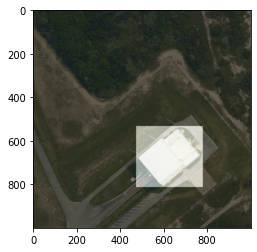

In [8]:
image_id = 5
image = train_set.load_image(image_id)
print(image.shape)
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)
pyplot.imshow(image)
pyplot.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
pyplot.show()


Display image with masks and bounding boxes

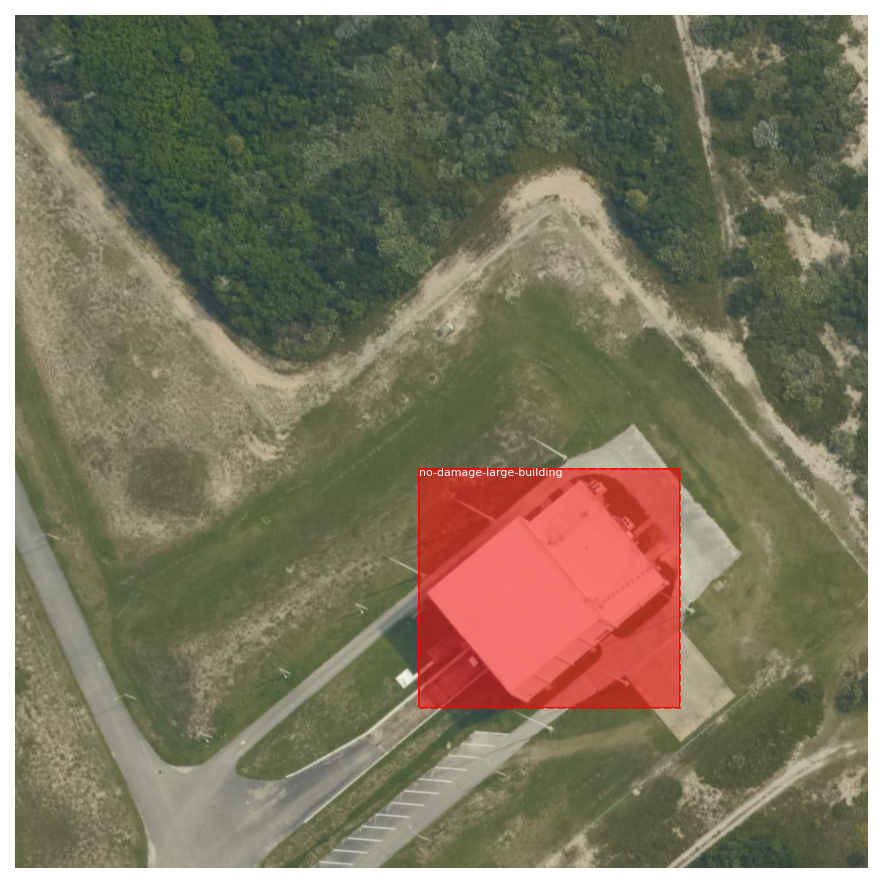

[array([[778. , 811.5],
        [777. , 811.5],
        [776. , 811.5],
        ...,
        [778.5, 810. ],
        [778.5, 811. ],
        [778. , 811.5]])]

In [9]:
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
image_id = 5
image = train_set.load_image(image_id)
mask, class_ids = train_set.load_mask(image_id)
bbox = extract_bboxes(mask)
display_instances(image, bbox, mask, class_ids, train_set.class_names)

Prepare config
Load weights
Train model 

In [10]:
debrisconfig = HurricaneConfig()
debrisconfig.display()
model = MaskRCNN(mode='training', config=debrisconfig, model_dir='/content/drive/My Drive')
model.load_weights('/content/drive/My Drive/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
model.train(train_set, test_set, learning_rate=debrisconfig.LEARNING_RATE, epochs=1, layers='heads')



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                27
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
38/39 [============================>.] - ETA: 2s - loss: 2.9527 - rpn_class_loss: 0.0908 - rpn_bbox_loss: 0.6842 - mrcnn_class_loss: 0.8764 - mrcnn_bbox_loss: 0.7023 - mrcnn_mask_loss: 0.5990

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


39/39 [==============================] - 135s 3s/step - loss: 2.9243 - rpn_class_loss: 0.0917 - rpn_bbox_loss: 0.6746 - mrcnn_class_loss: 0.8673 - mrcnn_bbox_loss: 0.6955 - mrcnn_mask_loss: 0.5952 - val_loss: 1.4937 - val_rpn_class_loss: 0.0448 - val_rpn_bbox_loss: 0.3055 - val_mrcnn_class_loss: 0.2586 - val_mrcnn_bbox_loss: 0.4836 - val_mrcnn_mask_loss: 0.4012


In [ ]:
import pickle
if os.path.exists("model_summary.pkl") == False:
	open("model_summary.pkl", 'w').close
pickle.dump(model.keras_model.summary(), open("model_summary.pkl", 'wb'))
model.keras_model.save_weights("model.h5")
print("Saved model summary and weights to disk")

Define the prediction configuration

In [19]:
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "debris_model_cfg"
	# number of classes (background + structures)
	NUM_CLASSES = 1 + 14
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

Calculate the mean absolute precision (mAP) for a model on a given dataset.

In [20]:
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP

Plot a number of images with ground truth and predictions.

In [21]:
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
	# load image and mask
	for i in range(n_images):
		# load the image and mask
		image = dataset.load_image(i)
		mask, _ = dataset.load_mask(i)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)[0]
		# define subplot
		pyplot.subplot(n_images, 2, i*2+1)
		# plot raw pixel data
		pyplot.imshow(image)
		pyplot.title('Actual')
		# plot masks
		for j in range(mask.shape[2]):
			pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
		# get the context for drawing boxes
		pyplot.subplot(n_images, 2, i*2+2)
		# plot raw pixel data
		pyplot.imshow(image)
		pyplot.title('Predicted')
		ax = pyplot.gca()
		# plot each box
		for box in yhat['rois']:
			# get coordinates
			y1, x1, y2, x2 = box
			# calculate width and height of the box
			width, height = x2 - x1, y2 - y1
			# create the shape
			rect = Rectangle((x1, y1), width, height, fill=False, color='red')
			# draw the box
			ax.add_patch(rect)
	# show the figure
	pyplot.show()

Evaluate mask rcnn model on training and test datasets.

In [ ]:
cfg = PredictionConfig()
model = MaskRCNN(mode='inference', config=cfg, model_dir='./')
model_path = 'model.h5'
model.load_weights(model_path, by_name=True)
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)
# Save model to JSON
import json
model_json = model.keras_model.to_json()
with open("mask_rcnn_debris.json", "w") as json_file:
    json_file.write(model_json)
json_file.close()  



Instructions for updating:
Use `tf.cast` instead.
Train mAP: 0.183


In [ ]:
plot_actual_vs_predicted(train_set, model, cfg)
plot_actual_vs_predicted(test_set, model, cfg)